# Read and Preprocess data

## import and functions

In [2]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
from TrackSelectorDNN.data_manager.dataset import TrackDatasetFromFile
from trackkit import preprocessing as pre
from trackkit import plotting as plot
from trackkit import summary as summ

In [1]:
INPUT_PATH  = "/shared/data/100_tracks_skip-connections_dataset.root"
OUTPUT_PATH = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_train-val_dataset_skip-connections.pt"
OUTPUT_PATH_TRAIN = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_train_dataset_skip-connections.pt"
OUTPUT_PATH_VAL  = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_val_dataset_skip-connections.pt"
MAX_HITS = 16

LOW_PERCENTILE  = 0.001
HIGH_PERCENTILE = 0.999
EPSILON = 1.e-8

# For the preselector

ONE_HOT_CONFIG = {
    "hltPixelTrack_nPixelHits": [2, 3, 4, 5, 6],
    "hltPixelTrack_nTrkLays":   [4, 5, 6, 7],
    "hltPixelTrack_ndof":       [3, 5, 7, 9],
}

# Continuous features used by the preselector (normalized)
PRE_CONTINUOUS_FEATURES = [
    "hltPixelTrack_chi2",
    "hltPixelTrack_eta",
    "hltPixelTrack_vx",
    "hltPixelTrack_vy",
    "hltPixelTrack_dxyBS",
]


#For the full DNN
recHitBranches = [
    "hltPixelTrackRecHits_globalX",
    "hltPixelTrackRecHits_globalY",
    "hltPixelTrackRecHits_globalZ",
    "hltPixelTrackRecHits_globalErrX",
    "hltPixelTrackRecHits_globalErrY",
    "hltPixelTrackRecHits_globalErrZ",
    "hltPixelTrackRecHits_globalR",
    "hltPixelTrackRecHits_globalEta",
    "hltPixelTrackRecHits_globalPhi"
]

recoPixelTrackBranches = [
    "hltPixelTrack_matched",
    "hltPixelTrack_isHighPurity",
    "hltPixelTrack_nPixelHits",
    "hltPixelTrack_nTrkLays",
    "hltPixelTrack_charge",
    "hltPixelTrack_chi2",
    "hltPixelTrack_dXY",
    "hltPixelTrack_dZ",
    "hltPixelTrack_dZError",
    "hltPixelTrack_dsz",
    "hltPixelTrack_dszErr",
    "hltPixelTrack_dxyError",
    "hltPixelTrack_eta",
    "hltPixelTrack_etaErr",
    "hltPixelTrack_lambdaErr",
    "hltPixelTrack_ndof",
    "hltPixelTrack_phi",
    "hltPixelTrack_phiErr",
    "hltPixelTrack_pt",
    "hltPixelTrack_ptErr",
    "hltPixelTrack_qoverp",
    "hltPixelTrack_qoverpErr",
    "hltPixelTrack_vx",
    "hltPixelTrack_vy",
    "hltPixelTrack_vz",
    "hltPixelTrack_dzBS",
    "hltPixelTrack_dxyBS"
]

In [3]:
def one_hot_encode_feature(x, values=None, cap=None):
    """
    x: (N,) array
    values: explicit categorical values
    bins: explicit integer bins
    cap: value above which everything goes to last bin
    """
    if cap is not None:
        x = np.minimum(x, cap)

    if values is not None:
        return np.stack([(x == v).astype(np.float32) for v in values], axis=1)

    raise ValueError("Specify values or bins")

## Preprocess input features for DNN

In [4]:
file = uproot.open(INPUT_PATH)
events = file["Events"]
data = events.arrays(library="ak")

recHitFeaturesList = []
for b in recHitBranches:
    arr = ak.to_numpy(ak.flatten(data[b])).reshape(-1,MAX_HITS)  # (n_tracks, MAX_HITS)
    recHitFeaturesList.append(arr)

recHitFeatures = np.stack(recHitFeaturesList, axis=2)  # (n_tracks, MAX_HITS, n_features)

# Create mask (1 = real hit, 0 = padded)
mask = np.isnan(recHitFeatures[:,:,0])  # (n_tracks, MAX_HITS)

# Replace NaNs with 0.0
recHitFeatures[mask] = 0
isRecHit = ~mask

recoPixelTrackList = []
for b in recoPixelTrackBranches:
    arr = ak.to_numpy(ak.flatten(data[b]))  # (n_tracks,)
    recoPixelTrackList.append(arr)


recoPixelTrackFeatures = np.stack(recoPixelTrackList[2:], axis=1)  # (n_tracks, n_features)
recoPixelTrackLabels = np.array(recoPixelTrackList[0])
recoPixelTrackIsHighPurity = np.array(recoPixelTrackList[1])
recoPixelTrackFeatures_names = recoPixelTrackBranches[2:]  # skip 'hltPixelTrack_matched and IsHP' (label)

mask_true = (recoPixelTrackLabels==1)
mask_fake = (recoPixelTrackLabels==0)

In [5]:
summary = summ.summarize_features(recoPixelTrackFeatures, recoPixelTrackFeatures_names)
summary_df = summ.print_summary_table(summary, sort_by="skew", top=15)
issues = summ.flag_outliers(summary)

                 feature        min          max        mean          std  zeros(%)  NaNs(%)       skew
     hltPixelTrack_ptErr   0.010045 1.433223e+09 3071.877197 1.788805e+06       0.0      0.0 765.888970
  hltPixelTrack_dxyError   0.000555 8.785193e+02    0.017971 1.158085e+00       0.0      0.0 662.876038
    hltPixelTrack_phiErr   0.000133 2.701934e+02    0.005183 3.632702e-01       0.0      0.0 634.179149
        hltPixelTrack_pt   0.714977 9.394304e+05    7.405170 1.305197e+03       0.0      0.0 601.802616
   hltPixelTrack_dZError   0.001625 1.035379e+00    0.032460 6.977922e-02       0.0      0.0   4.356475
    hltPixelTrack_dszErr   0.000716 6.550348e-02    0.006379 3.704132e-03       0.0      0.0   2.515072
  hltPixelTrack_nTrkLays   4.000000 1.300000e+01    4.684345 1.350544e+00       0.0      0.0   2.106191
hltPixelTrack_nPixelHits   2.000000 1.500000e+01    3.637904 2.297436e+00       0.0      0.0   2.022868
      hltPixelTrack_ndof   3.000000 2.500000e+01    4.976957 3.8

In [6]:
summary = summ.summarize_features(recoPixelTrackFeatures, recoPixelTrackFeatures_names)
summary_df = summ.print_summary_table(summary, sort_by="skew", top=15)
issues = summ.flag_outliers(summary)

                 feature        min          max        mean          std  zeros(%)  NaNs(%)       skew
     hltPixelTrack_ptErr   0.010045 1.433223e+09 3071.877197 1.788805e+06       0.0      0.0 765.888970
  hltPixelTrack_dxyError   0.000555 8.785193e+02    0.017971 1.158085e+00       0.0      0.0 662.876038
    hltPixelTrack_phiErr   0.000133 2.701934e+02    0.005183 3.632702e-01       0.0      0.0 634.179149
        hltPixelTrack_pt   0.714977 9.394304e+05    7.405170 1.305197e+03       0.0      0.0 601.802616
   hltPixelTrack_dZError   0.001625 1.035379e+00    0.032460 6.977922e-02       0.0      0.0   4.356475
    hltPixelTrack_dszErr   0.000716 6.550348e-02    0.006379 3.704132e-03       0.0      0.0   2.515072
  hltPixelTrack_nTrkLays   4.000000 1.300000e+01    4.684345 1.350544e+00       0.0      0.0   2.106191
hltPixelTrack_nPixelHits   2.000000 1.500000e+01    3.637904 2.297436e+00       0.0      0.0   2.022868
      hltPixelTrack_ndof   3.000000 2.500000e+01    4.976957 3.8

In [7]:
do_log_track = []
# Variables to log-transform and clip
log_vars = ["hltPixelTrack_pt", "hltPixelTrack_ptErr", 
            "hltPixelTrack_dxyError", "hltPixelTrack_phiErr", 
            "hltPixelTrack_chi2", "hltPixelTrack_dszErr",
            "hltPixelTrack_dZError", "hltPixelTrack_qoverpErr", "hltPixelTrack_lambdaErr", "hltPixelTrack_etaErr"]

recoPixelTrackFeatures_proc = recoPixelTrackFeatures.copy()
for i, name in enumerate(recoPixelTrackFeatures_names):
    do_log_track.append(name in log_vars)
    if name in log_vars:
        x = recoPixelTrackFeatures_proc[:, i]
        x = np.log10(EPSILON+x)
        recoPixelTrackFeatures_proc[:, i] = x
clip_min_track = []
clip_max_track = []
# Variables to just clip
clip_vars = [
    "hltPixelTrack_pt", "hltPixelTrack_ptErr", 
    "hltPixelTrack_dxyError", "hltPixelTrack_phiErr", 
    "hltPixelTrack_chi2", "hltPixelTrack_dszErr",
    "hltPixelTrack_dZError", "hltPixelTrack_qoverpErr", "hltPixelTrack_lambdaErr", "hltPixelTrack_etaErr",
    "hltPixelTrack_dXY", "hltPixelTrack_dsz", 
    "hltPixelTrack_vx", "hltPixelTrack_vy"]

for i, name in enumerate(recoPixelTrackFeatures_names):
    if name in clip_vars:
        x = recoPixelTrackFeatures_proc[:, i]
        x, lo, hi = pre.clip_outliers(x, low=LOW_PERCENTILE, high=HIGH_PERCENTILE)
        recoPixelTrackFeatures_proc[:, i] = x
        clip_min_track.append(lo)
        clip_max_track.append(hi)
    else:
        clip_min_track.append(np.nan)
        clip_max_track.append(np.nan)

recoPixelTrackFeaturesNorm, recoPixelTrack_mean, recoPixelTrack_std = pre.normalize_2d(recoPixelTrackFeatures_proc)
summary_norm = summ.summarize_features(recoPixelTrackFeaturesNorm, recoPixelTrackFeatures_names)
summary_norm_df = summ.print_summary_table(summary_norm, sort_by="skew", top=15)
issues = summ.flag_outliers(summary_norm)

                 feature       min      max          mean      std  zeros(%)  NaNs(%)      skew
     hltPixelTrack_ptErr -1.545767 8.240782  6.279343e-05 1.000136  0.000000      0.0  2.558436
        hltPixelTrack_pt -1.037408 7.116273  6.366129e-06 1.000119  0.000000      0.0  2.431529
  hltPixelTrack_nTrkLays -0.507254 6.163778  1.090239e-07 1.001058  0.000000      0.0  2.106190
hltPixelTrack_nPixelHits -0.711604 4.936378  6.310129e-08 0.998145  0.000000      0.0  2.022867
      hltPixelTrack_ndof -0.518378 5.250238  1.776485e-08 0.998556  0.000000      0.0  2.019704
  hltPixelTrack_dxyError -2.317647 5.481570 -1.451044e-04 1.000169  0.000000      0.0  1.630208
   hltPixelTrack_dZError -1.484944 3.382557 -9.955909e-05 1.000149  0.000000      0.0  1.252644
    hltPixelTrack_phiErr -2.802015 5.387320  1.400126e-04 1.000175  0.000000      0.0  1.086600
      hltPixelTrack_chi2 -4.631482 2.222344  1.185957e-04 1.000109  0.000000      0.0 -0.921590
 hltPixelTrack_qoverpErr -3.746379 2.112

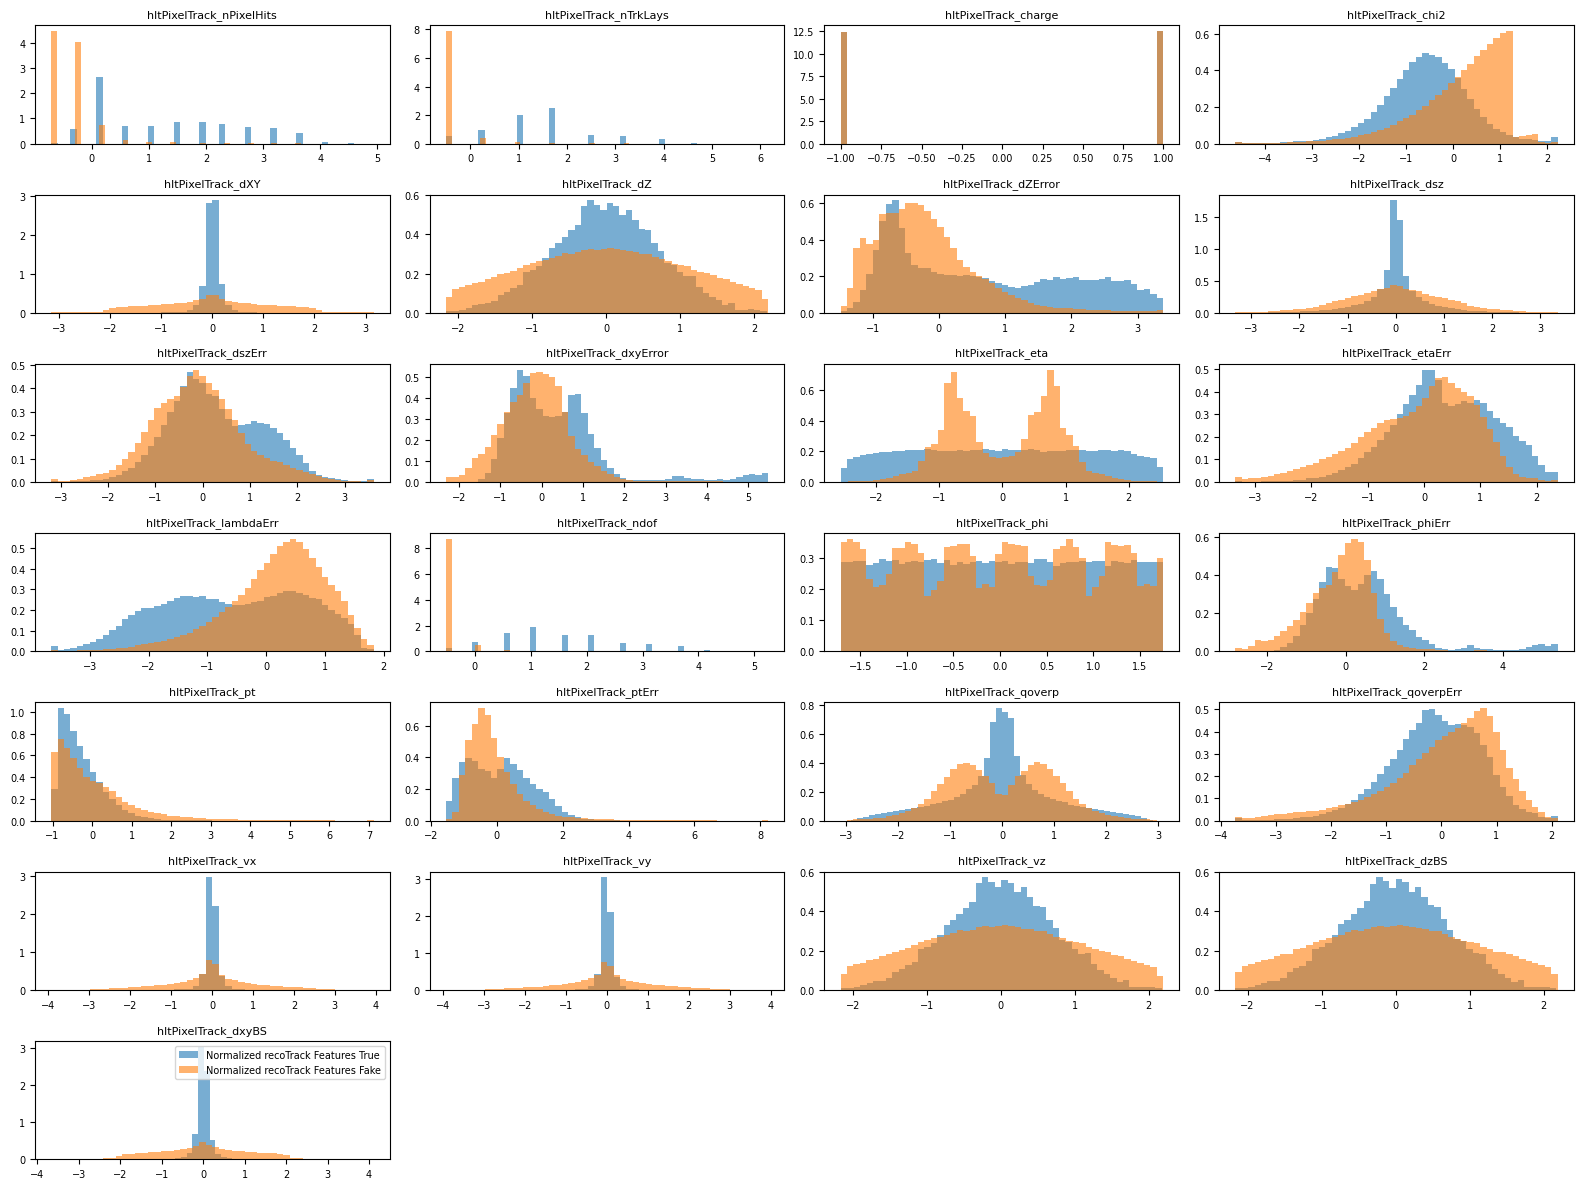

In [8]:
plot.plot_feature_distributions(
    X_ref=recoPixelTrackFeaturesNorm,
    feature_names=recoPixelTrackFeatures_names,
    y=recoPixelTrackLabels,
    labels=("Normalized recoTrack Features",)
)

In [9]:
summary_recHits = summ.summarize_recHits(recHitFeatures, isRecHit, recHitBranches)
summary_recHits_df = summ.print_summary_table(summary_recHits, sort_by="skew", top=15)
issues_recHits = summ.flag_outliers(summary_recHits)

                        feature       n           min        max      mean       std  zeros(%)      skew
hltPixelTrackRecHits_globalErrY 3376392  8.275480e-36   0.001625  0.000139  0.000344  1.751752  2.609381
hltPixelTrackRecHits_globalErrX 3376392  6.770847e-36   0.001572  0.000140  0.000344  1.285100  2.606822
hltPixelTrackRecHits_globalErrZ 3376392  0.000000e+00   0.001793  0.000216  0.000458 36.683951  2.514691
   hltPixelTrackRecHits_globalR 3376392  2.750000e+00  55.250000 14.204810 11.255790  0.000000  1.126762
 hltPixelTrackRecHits_globalEta 3376392 -4.312500e+00   4.312500  0.013474  1.928022  0.002725 -0.010637
   hltPixelTrackRecHits_globalZ 3376392 -2.660000e+02 266.000000  0.394046 68.181557  0.002725  0.005219
   hltPixelTrackRecHits_globalX 3376392 -5.500000e+01  55.000000 -0.023733 12.838006  0.000000 -0.004666
   hltPixelTrackRecHits_globalY 3376392 -5.525000e+01  55.250000  0.005018 12.792507  0.000000 -0.001371
 hltPixelTrackRecHits_globalPhi 3376392 -3.140625e+00  

In [10]:
do_log_hit = []
log_recHit_vars = ["hltPixelTrackRecHits_globalR", "hltPixelTrackRecHits_globalErrX", "hltPixelTrackRecHits_globalErrY", "hltPixelTrackRecHits_globalErrZ"]
       
recHitFeatures_proc = recHitFeatures.copy()
for f, name in enumerate(recHitBranches):
    do_log_hit.append(name in log_recHit_vars)
    if name in log_recHit_vars:
        print(f, name)
        recHitFeatures_proc = pre.masked_log_transform(recHitFeatures_proc, isRecHit, f, eps=EPSILON, method='log_eps')

recHitFeatures_norm, recHit_mean, recHit_std = pre.normalize_features_masked(recHitFeatures_proc, isRecHit, eps=EPSILON)
clip_min_hit = [np.nan for i in enumerate(recHitBranches)]
clip_max_hit = [np.nan for i in enumerate(recHitBranches)]

3 hltPixelTrackRecHits_globalErrX
4 hltPixelTrackRecHits_globalErrY
5 hltPixelTrackRecHits_globalErrZ
6 hltPixelTrackRecHits_globalR


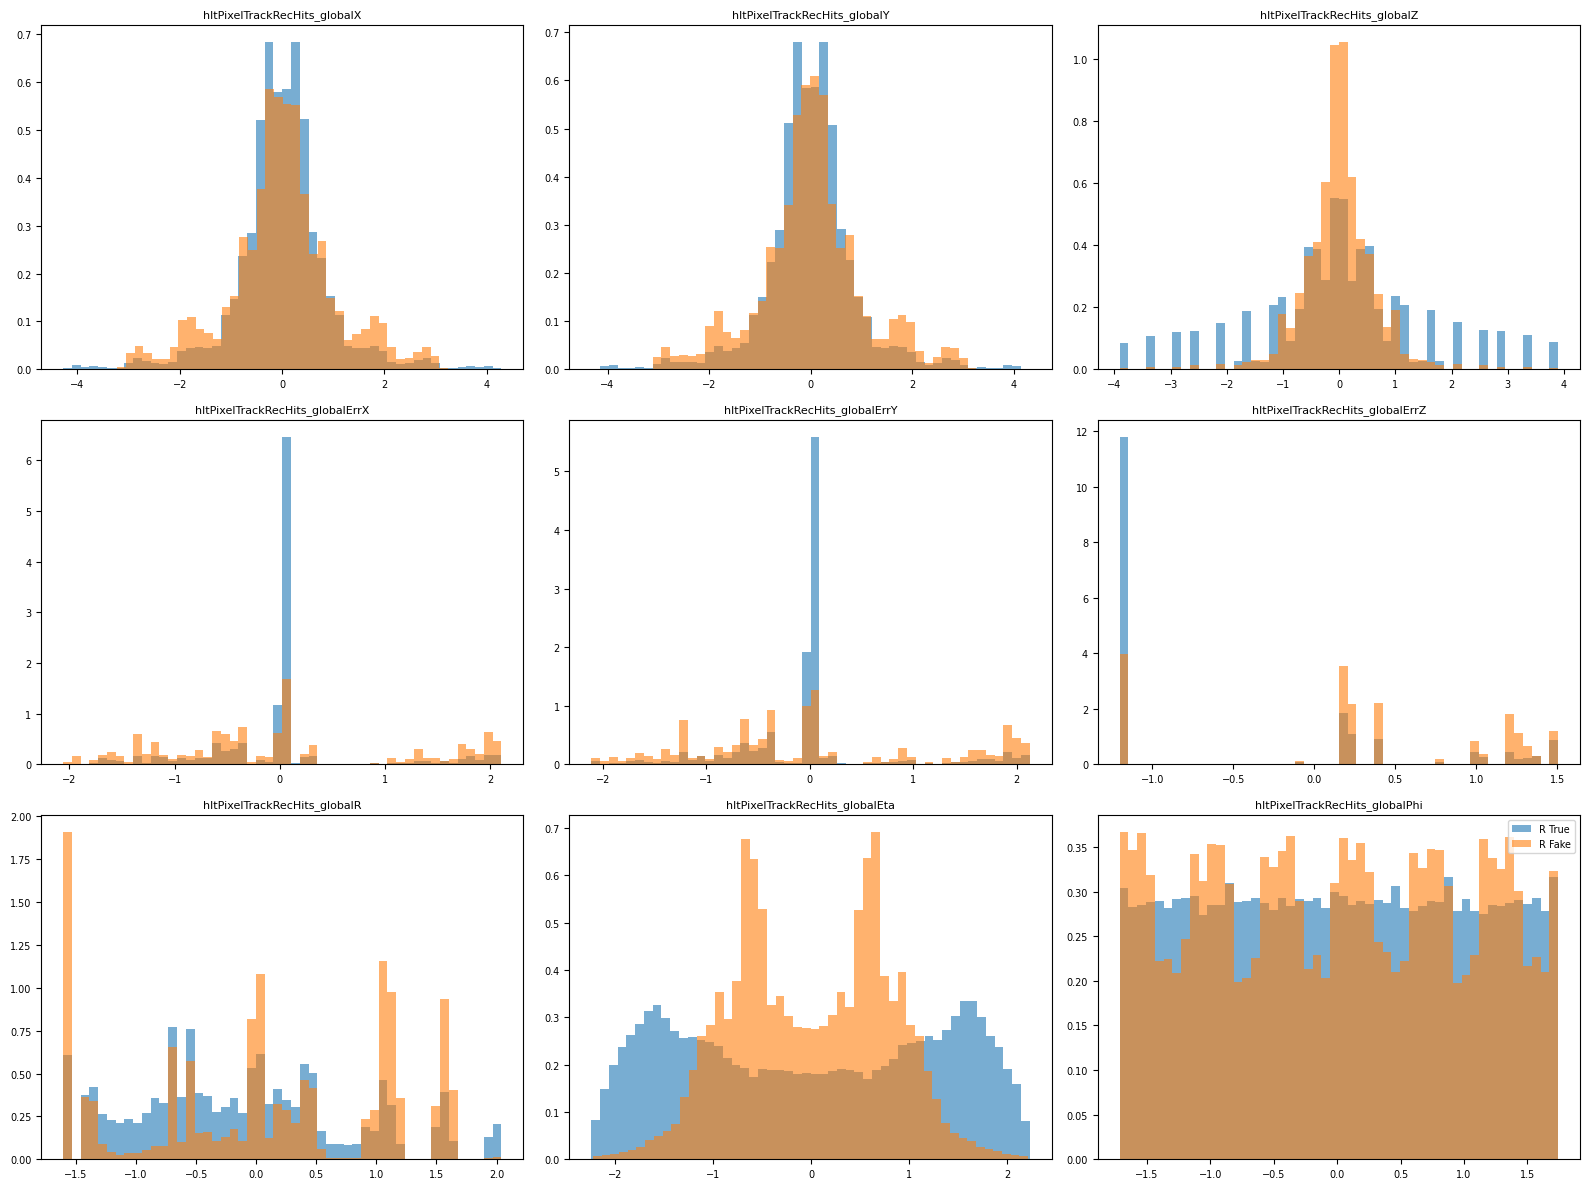

In [11]:
recHitFeatures_norm_plot = np.array(pre.masked_flatten(recHitFeatures_norm, isRecHit)).T
y_hits = np.repeat(recoPixelTrackLabels, isRecHit.sum(axis=1))  # only if you want to compare by label

plot.plot_feature_distributions(
    X_ref=recHitFeatures_norm_plot,
    feature_names=recHitBranches,
    y=y_hits,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

## Preprocess input features for Preselector

In [26]:
cont_indices = [recoPixelTrackFeatures_names.index(n) for n in PRE_CONTINUOUS_FEATURES]
X_cont = recoPixelTrackFeaturesNorm[:, cont_indices]
onehot_blocks = []
onehot_names  = []

for name, values in ONE_HOT_CONFIG.items():
    idx = recoPixelTrackFeatures_names.index(name)
    oh = one_hot_encode_feature(recoPixelTrackFeatures[:, idx], values, cap=max(values))
    onehot_blocks.append(oh)
    onehot_names.extend([f"{name}=={v}" for v in values])

X_onehot = np.concatenate(onehot_blocks, axis=1)

# Final preselector input
X_pre = np.concatenate([X_cont, X_onehot], axis=1)
pre_names = PRE_CONTINUOUS_FEATURES + onehot_names

In [27]:
pre_names

['hltPixelTrack_chi2',
 'hltPixelTrack_eta',
 'hltPixelTrack_vx',
 'hltPixelTrack_vy',
 'hltPixelTrack_dxyBS',
 'hltPixelTrack_nPixelHits==2',
 'hltPixelTrack_nPixelHits==3',
 'hltPixelTrack_nPixelHits==4',
 'hltPixelTrack_nPixelHits==5',
 'hltPixelTrack_nPixelHits==6',
 'hltPixelTrack_nTrkLays==4',
 'hltPixelTrack_nTrkLays==5',
 'hltPixelTrack_nTrkLays==6',
 'hltPixelTrack_nTrkLays==7',
 'hltPixelTrack_ndof==3',
 'hltPixelTrack_ndof==5',
 'hltPixelTrack_ndof==7',
 'hltPixelTrack_ndof==9']

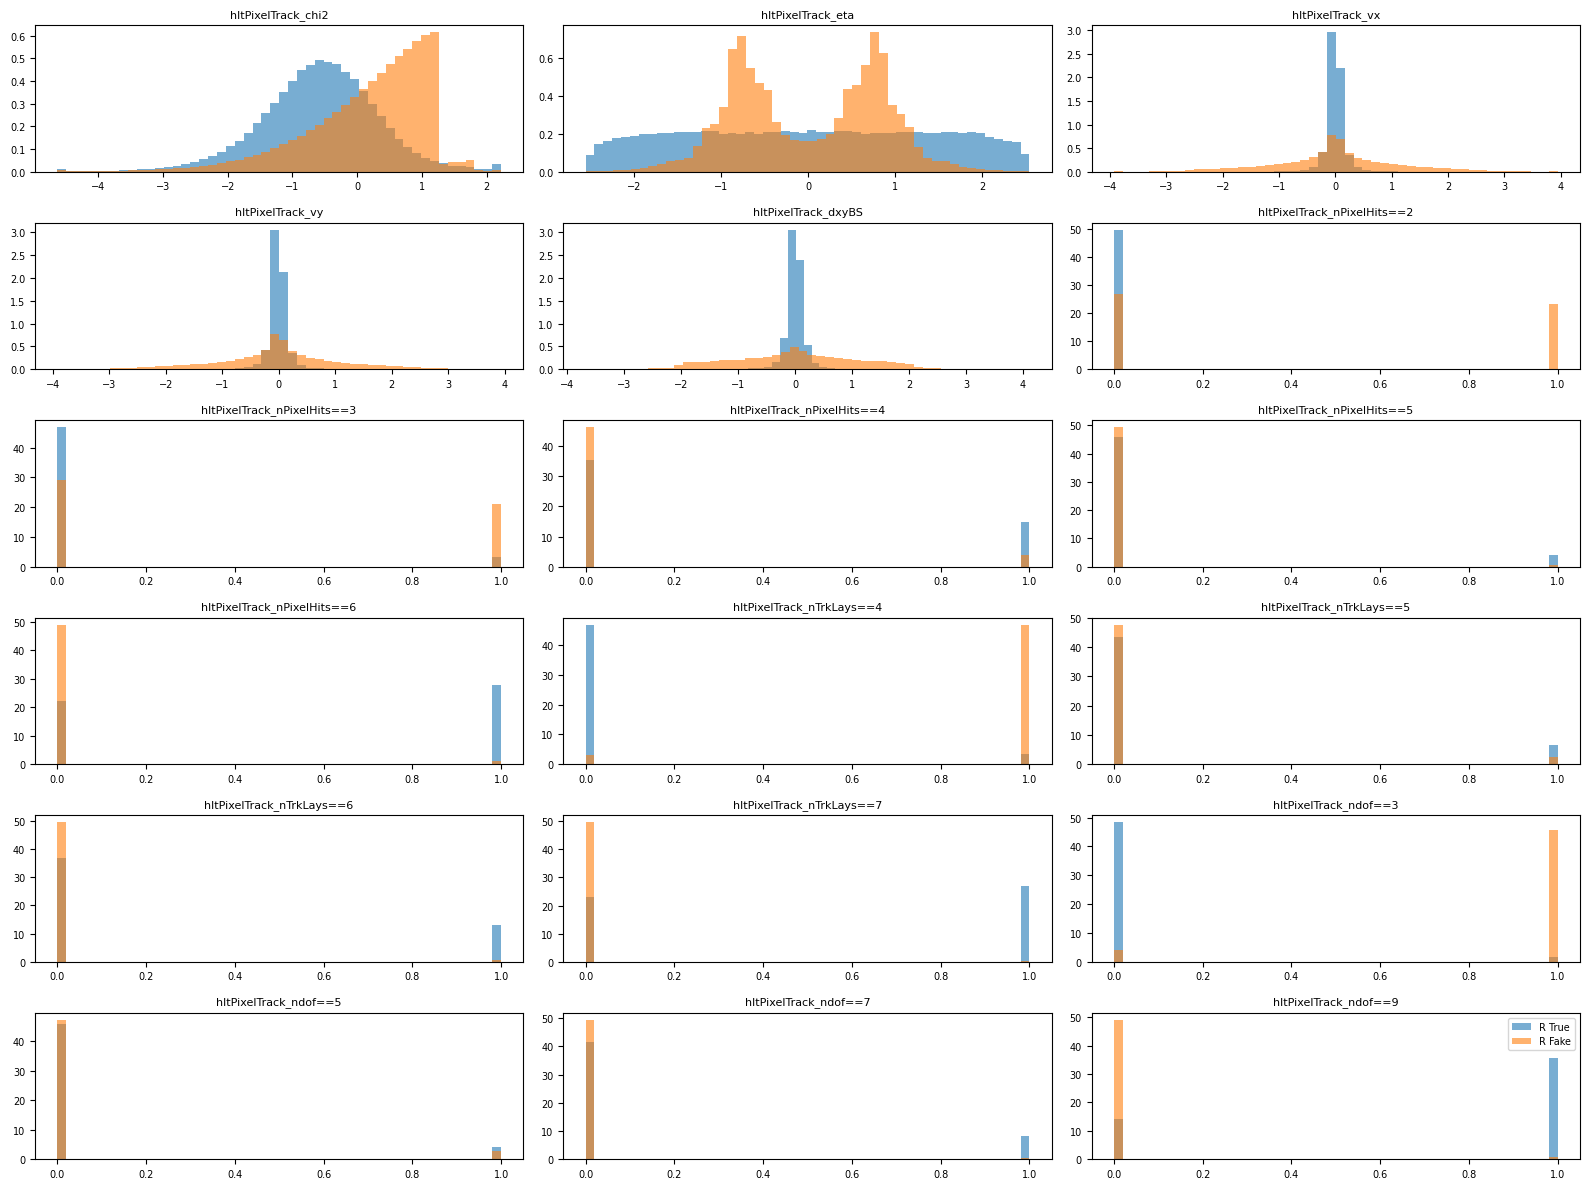

In [30]:
plot.plot_feature_distributions(
    X_ref=X_pre,
    feature_names=pre_names,
    y=recoPixelTrackLabels,
    labels=("Raw recHits"),
    n_cols=3,
    bins=50
)

In [29]:
def plot_feature_2d(
    X,
    feature_names,
    i,
    j,
    y=None,
    max_points=100_000,
    bins=100,
    figsize=(5, 5),
    density=True,
    cmap_true="Blues",
    cmap_fake="Reds",
):
    assert i < X.shape[1] and j < X.shape[1]

    # Subsample for speed
    N = X.shape[0]
    if N > max_points:
        idx = np.random.choice(N, max_points, replace=False)
        X = X[idx]
        if y is not None:
            y = y[idx]

    plt.figure(figsize=figsize)

    if y is None:
        plt.hist2d(
            X[:, i],
            X[:, j],
            bins=bins,
            density=density,
            cmap="viridis",
        )
        plt.colorbar(label="Density")
    else:
        mask_true = (y == 1)
        mask_fake = (y == 0)

        plt.hist2d(
            X[mask_fake, i],
            X[mask_fake, j],
            bins=bins,
            density=density,
            cmap=cmap_fake,
            alpha=0.6,
        )
        plt.hist2d(
            X[mask_true, i],
            X[mask_true, j],
            bins=bins,
            density=density,
            cmap=cmap_true,
            alpha=0.6,
        )

        plt.colorbar(label="Density")

    plt.xlabel(feature_names[i])
    plt.ylabel(feature_names[j])
    plt.title(f"{feature_names[i]} vs {feature_names[j]}")
    plt.tight_layout()
    plt.show()

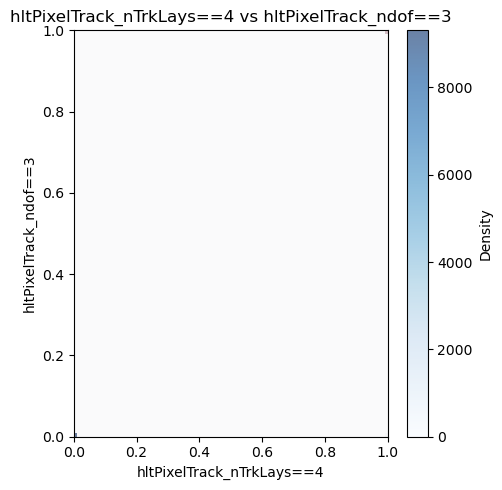

In [33]:
plot_feature_2d(
    X_pre,
    pre_names,
    10, 14,
    y=recoPixelTrackLabels
)

## Save data

In [34]:
save_dict = {
    # --- Core datasets ---
    "recHitFeatures": torch.tensor(recHitFeatures_norm, dtype=torch.float32),
    "isRecHit": torch.tensor(isRecHit, dtype=torch.bool),
    "recoPixelTrackFeatures": torch.tensor(recoPixelTrackFeaturesNorm, dtype=torch.float32),
    "labels": torch.tensor(recoPixelTrackLabels, dtype=torch.float32),
    "isHighPurity": torch.tensor(recoPixelTrackIsHighPurity, dtype=torch.bool),

    # --- Normalization stats ---
    "recHit_mean": torch.tensor(recHit_mean, dtype=torch.float32),
    "recHit_std": torch.tensor(recHit_std, dtype=torch.float32),
    "recoPixelTrack_mean": torch.tensor(recoPixelTrack_mean, dtype=torch.float32),
    "recoPixelTrack_std": torch.tensor(recoPixelTrack_std, dtype=torch.float32),
    
    # --- Metadata ---
    "recHitBranches": recHitBranches,
    "recoPixelTrackBranches": recoPixelTrackBranches[2:],  # exclude label and isHP
    "MAX_HITS": MAX_HITS,
    "EPSILON": EPSILON,
    "LOW_PERCENTILE": LOW_PERCENTILE,
    "HIGH_PERCENTILE": HIGH_PERCENTILE,
    "log_vars": log_vars,
    "clip_vars": clip_vars,
    "log_recHit_vars": log_recHit_vars,
    "do_log_hit": torch.tensor(do_log_hit, dtype=torch.bool),
    "clip_min_hit": torch.tensor(clip_min_hit, dtype=torch.float32),
    "clip_max_hit": torch.tensor(clip_max_hit, dtype=torch.float32),
    "do_log_track": torch.tensor(do_log_track, dtype=torch.bool),
    "clip_min_track": torch.tensor(clip_min_track, dtype=torch.float32),
    "clip_max_track": torch.tensor(clip_max_track, dtype=torch.float32),

    # New preselector view
    "recoPixelTrackFeatures_pre": torch.tensor(X_pre, dtype=torch.float32),
    "recoPixelTrackFeatures_pre_names": pre_names,
    "recoPixelTrackFeatures_pre_is_onehot": (
        [False] * len(PRE_CONTINUOUS_FEATURES)
        + [True] * X_onehot.shape[1]
    ),

    # Normalization stats (only for continuous features)
    "recoPixelTrack_pre_mean": torch.tensor(recoPixelTrack_mean[..., cont_indices], dtype=torch.float32),
    "recoPixelTrack_pre_std": torch.tensor(recoPixelTrack_std[..., cont_indices], dtype=torch.float32),
}

torch.save(save_dict, OUTPUT_PATH)
print(f"Saved preselector dataset to {OUTPUT_PATH}")

Saved preselector dataset to /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/100_tracks_train-val_dataset_skip-connections.pt
